In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, csv, matplotlib.pyplot as plt
import torch.nn as nn, timeit, torch, pystan as ps
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import LocallyLinearEmbedding
from tqdm import trange
%matplotlib inline
from time import time
from pylab import plot, show, legend

In [2]:
sm = ps.StanModel(file="/home/postdoc/dsen/Desktop/VAE_density/stan_files/nn_refpoints_constrainedtheta.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_569673e5f92a27b1e5ae773cc5c59d5e NOW.


In [3]:
M = 1000
Z = 10*npr.rand(2,M)
X = np.zeros((3,M))
X[0] = np.cos(Z[0])*np.cos(Z[1])
X[1] = np.cos(Z[0])*np.sin(Z[1])
X[2] = np.sin(Z[0])

idx = X[2]>0
X = X[:,idx]
Z = Z[:,idx]
X += 0.1*npr.rand(*np.shape(X))
Nobs = np.shape(Z)[1]

In [4]:
Nobs

604

### Local linear embedding for reference points:

In [5]:
n_ref = 0
ref_points = npr.choice(Nobs,n_ref,replace=False)
embedding = LocallyLinearEmbedding(n_components=2,n_neighbors=10)
X_embedded = embedding.fit_transform(X.transpose()).transpose()

In [6]:
train = np.setdiff1d(np.arange(Nobs), ref_points)
X_ref = X[:,ref_points]
Z_ref = X_embedded[:,ref_points]
X_train = X[:,train]

In [7]:
n_in = np.shape(X_embedded)[0]
n_h = 10
n_out = np.shape(X)[0]

model = nn.Sequential(nn.Linear(n_in, n_h),
                      nn.Tanh(),
                      nn.Linear(n_h, n_out))

In [8]:
def init_normal(m):
    if type(m) == nn.Linear: nn.init.normal_(m.weight)
model.apply(init_normal)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

In [9]:
n_iter = 10_000
Lss = np.zeros(n_iter)
start = time()
for epoch in range(n_iter):
    X_pred = model(torch.from_numpy(Z_ref.transpose().astype(np.float32)))
    loss = criterion(X_pred, torch.from_numpy(X_ref.transpose().astype(np.float32)))
    Lss[epoch] = loss.data
    if (epoch+1)%(n_iter/10) == 0 :
        print("Epoch: %d; loss: %.3f; time: %.1f mins" % (epoch+1, loss.item(), (time()-start)/60))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 1000; loss: nan; time: 0.0 mins
Epoch: 2000; loss: nan; time: 0.0 mins
Epoch: 3000; loss: nan; time: 0.0 mins
Epoch: 4000; loss: nan; time: 0.0 mins
Epoch: 5000; loss: nan; time: 0.0 mins
Epoch: 6000; loss: nan; time: 0.0 mins
Epoch: 7000; loss: nan; time: 0.0 mins
Epoch: 8000; loss: nan; time: 0.0 mins
Epoch: 9000; loss: nan; time: 0.0 mins
Epoch: 10000; loss: nan; time: 0.1 mins


In [10]:
for (i,p) in enumerate(model.parameters()):
    if i == 0 : W_1_optim = p.data;
    print(np.shape(p))

torch.Size([10, 2])
torch.Size([10])
torch.Size([3, 10])
torch.Size([3])


In [11]:
c = [np.linalg.norm(W_1_optim[i,:]) for i in range(n_in)]
for i in range(n_ref) : Z_ref[:,i] *= c

In [12]:
data = dict(Nobs=Nobs, in_dim=np.shape(Z)[0], out_dim=np.shape(X)[0], hidden_dim=n_h,
            n_ref=np.shape(X_ref)[1], X=X_train, X_ref=X_ref, Z_ref=Z_ref)

### Run Stan:

In [13]:
# control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=10, chains=10, init="random", iter=1_000)
print(round((time()-start)/60,2), "minutes to run")
print(fit);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


35.7 minutes to run
Inference for Stan model: anon_model_569673e5f92a27b1e5ae773cc5c59d5e.
10 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=5000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Z[1,1]               0.54     0.7   1.56  -1.99  -1.34   1.48   1.74   2.32      5  15.95
Z[2,1]              -0.07    0.35   0.79  -0.94  -0.68  -0.47   0.64   1.43      5   5.59
Z[3,1]              -0.39     0.3   0.68  -1.86  -0.73  -0.61    0.4    0.8      5   5.53
Z[4,1]              -0.15     0.6   1.34  -2.44  -1.38  -0.05   1.11   1.72      5   12.1
Z[5,1]              -0.68    0.52   1.16  -2.01  -1.61  -0.95   0.36   1.91      5  14.78
Z[6,1]              -0.19    0.49   1.11  -3.24  -0.54  -0.13   0.71   1.09      5  10.11
Z[7,1]              -0.76    0.29   0.67  -1.62   -1.3  -0.92   -0.4   0.45      5   6.04
Z[8,1]              -0.24    0.79   1.78  -4.56  -1.22   0.26   1.33   1

In [14]:
trace = fit.extract()
n_samples, n_latent = np.shape(trace['Z'])[0], np.shape(trace['Z'])[1]

#### Traceplots of latent variables:

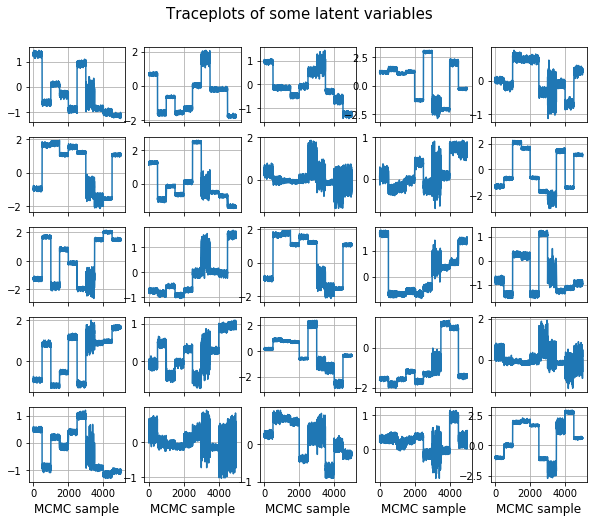

In [24]:
plt.figure(figsize=(10,8))
idx = npr.choice(n_latent,25).reshape(5,5)

for i in range(5):
    for j in range(5):
        k = 5*i+j
        plt.subplot(5,5,k+1)
        plt.plot(trace['Z'][:,idx[i,j],0])
        if i < 4 : plt.xticks(alpha=0)
        if i == 4 : plt.xlabel("MCMC sample", fontsize=12)
        plt.grid(True)
plt.suptitle("Traceplots of some latent variables", fontsize=15, x=0.5,y=0.95)
plt.show()

### Loss:

In [16]:
def L2_loss(X, Z, weights_1, bias_1, weights_2, bias_2) :
    X_pred = np.matmul(np.tanh(np.matmul(Z,weights_1)+bias_1), weights_2) + bias_2
    return np.mean(np.sum((X-X_pred)**2,axis=1))

100%|██████████| 5000/5000 [00:00<00:00, 6343.70it/s]


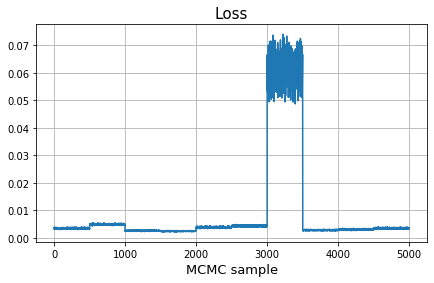

In [18]:
loss = np.zeros(n_samples)
for i in trange(n_samples) :
    loss[i] = L2_loss(X_train.transpose(), trace['Z'][i], trace['weights_1'][i], 
                      trace['bias_1'][i], trace['weights_2'][i], trace['bias_2'][i])
plt.figure(figsize=(7,4))
plt.plot(loss)
plt.title("Loss", fontsize=15)
plt.xlabel("MCMC sample", fontsize=13)
plt.grid(True)
# plt.savefig('plots/loss_constrainedtheta_refpoints.pdf', dpi=1000, bbox_inches='tight');

### Pairwise distances:

In [19]:
k_max = 50

pw_dist_matrix = np.zeros((n_latent,n_latent,n_samples))
for i in trange(k_max) :
    for j in range(k_max) :
        for k in range(n_samples) :
            pw_dist_matrix[i,j,k] = np.linalg.norm(trace['Z'][k,i]-trace['Z'][k,j])

100%|██████████| 50/50 [00:58<00:00,  1.21s/it]


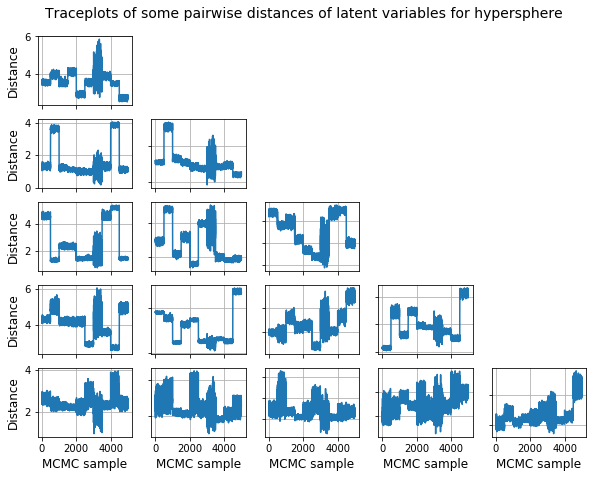

In [44]:
idx = npr.choice(k_max,10,replace=False)
plt.figure(figsize=(20,15))
for i in range(6):
    for j in range(6):
        if i > j :
            k = 10*i+j+1
            plt.subplot(10,10,k)
            plt.plot(pw_dist_matrix[idx[i],idx[j]])
            if i < 5 : plt.xticks(alpha=0)
            plt.grid(True)
            if i == 5 : plt.xlabel("MCMC sample", fontsize=12)
            if j > 0 : plt.yticks(alpha=0)
            if j == 0 : plt.ylabel("Distance", fontsize=12)
plt.suptitle("Traceplots of some pairwise distances of latent variables for hypersphere", fontsize=14, x=0.31,y=0.83)
plt.savefig('/home/postdoc/dsen/Desktop/VAE_density/plots/sphere_pwdist_unconstrainedW1_norefpoints.pdf', 
                dpi=2000, bbox_inches='tight');